<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/autocorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autocorrelation**

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## **Relevance**

* Used as input parameter in classical time series models, such as (S)Arima(x), Garch or Auto Vectorregression (VaR), to identify for example seasonality.
* Most financial time series exhibit some form of autocorrelation
* A series can contain autocorrelation an be stationary, as long as there is a constant autocorrelation structure over time (and series has no trend, constant variance over time, and no periodic fluctuations like seasonality).
* But if autocorrelation is zero does NOT mean that a process is stationary. Generally autocorrelation doesn't cause non-stationarity, and non-stationarity doesn't require autocorrelation.
* Can be used to test whether a series is independent (as part of IID), by testing that the autocorrelations at all non zero lags are 0 (using if the data have an index ordering).
* Portmanteau tests are statistical tests that can be used to test whether several autocorrelation coefficients differ significantly from zero. This is particularly important when checking the residuals' freedom from autocorrelation during the diagnosis phase of a time series analysis. Portmanteau tests are purely significance tests. You are not testing against a clearly formulated counter-hypothesis. The test statistic is called Q statistic.

**Create Example Data: (Gaussian) White Noise**

In [0]:
# Set seed for reproducibility and hyperparameter

from random import gauss
from random import seed
from pandas import Series

seed(1)
mean = 0.0
sigma = 1.0
periods = 5000

# Create White Noise
whitenoise = [gauss(mean, sigma) for i in range(periods)]
whitenoise = pd.DataFrame(data=Series(whitenoise), columns=['whitenoise'])

# Create Time Series
ts = pd.date_range('2010-01-01', periods=periods, freq='D')
ts = pd.DataFrame(data=ts, columns=['ts'])

# Merge and Set Index
series = pd.concat([ts, whitenoise], axis=1).set_index('ts')
series.head()

,whitenoise
ts,
2010-01-01,1.288185
2010-01-02,1.449446
2010-01-03,0.066336
2010-01-04,-0.764544
2010-01-05,-1.092173


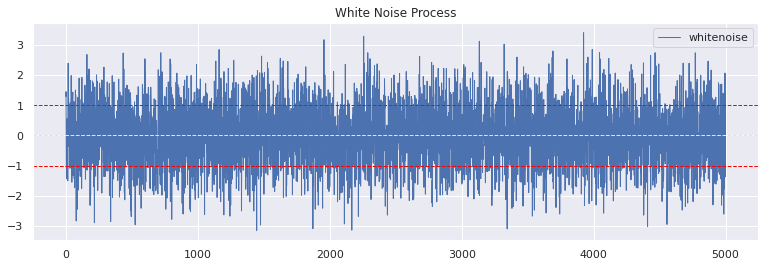

In [0]:
# Visualize Series
sns.set(rc={'figure.figsize':(13, 4), "lines.linewidth": 1.0})
whitenoise.plot(title='White Noise Process')
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.0)
plt.axhline(y=-1, color='red', linestyle='--', linewidth=1.0)
plt.axhline(y=0, color='yellow', linestyle='--', linewidth=1.0)

## **Autocorrelation Plots**

**Autocorrelation Plot**

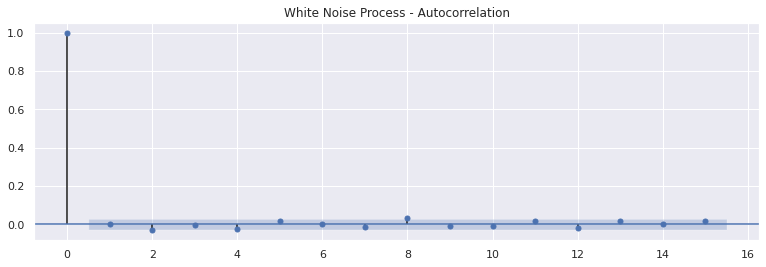

In [0]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series.squeeze(), lags=15)
plt.title('White Noise Process - Autocorrelation')
plt.show()

There may be some spikes above the 95% and 99% confidence level, but these are a statistical fluke.

**Partial Autocorrelation Lag Plot**

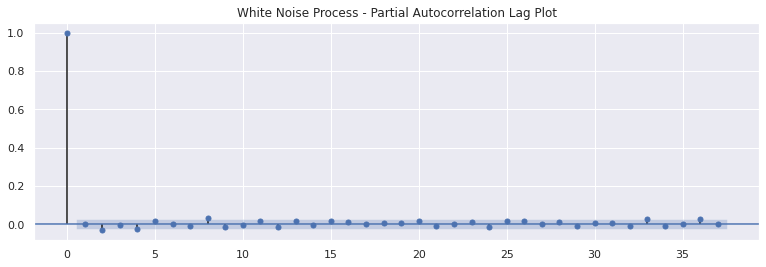

In [0]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(series)
plt.title('White Noise Process - Partial Autocorrelation Lag Plot')
plt.show()

**Lag Plot**

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


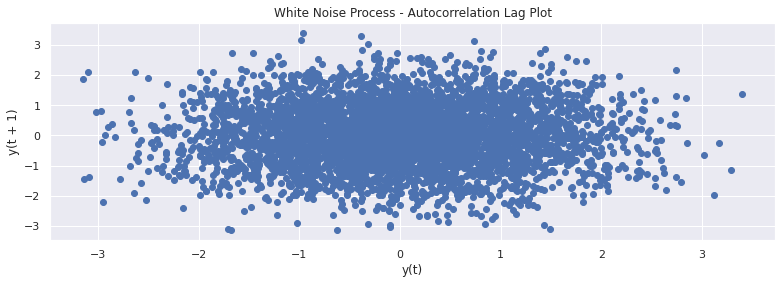

In [0]:
from pandas.plotting import lag_plot
lag_plot(series)
plt.title('White Noise Process - Autocorrelation Lag Plot')
plt.show()

## **Statistical Tests**

**Durban-Watson Statistic**

* Is a test for autocorrelation in the residuals from a statistical regression analysis.
* The null hypothesis of the test is that there is no serial correlation
* This statistic will always be between 0 and 4. Closer to 0: evidence for positive serial correlation, closer to 4: negative serial correlation. 2 means no autocorrelation.

In [0]:
# Durban-Watson Statistic. Value 2: no serial correlation. 0: positive correlation. 4: negative correlation
import statsmodels.api as sm
import statsmodels.tsa.stattools
statsmodels.stats.stattools.durbin_watson(series, axis=0)

array([1.99873153])

Test statistic is close to 2. There is no autocorrelation present.

**Ljung-Box Q Statistic**

* Ljung–Box test is an improved version of the Box–Pierce test
* Returns Ljung-Box Q-statistic for autocorrelation parameters and p-value
* Examining the null hypothesis of independence in a given time series.
* Instead of testing randomness at each distinct lag, it tests the "overall" randomness based on a number of lags, and is therefore a portmanteau test.
* The Ljung-Box Q (LBQ) statistic tests the null hypothesis that autocorrelations up to lag k equal zero (that is, the data values are random and independent up to a certain number of lags--in this case 12). 
* If the LBQ is greater than a specified critical value, autocorrelations for one or more lags might be significantly different from zero, indicating the values are not random and independent over time.
* https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/supporting-topics/diagnostic-checking/what-is-the-ljung-box-q-statistic/
* There are some strong voices in the Econometrics community against the validity of the Ljung-Box Q-statistic for testing for autocorrelation based on the residuals from an autoregressive model (i.e. with lagged dependent variables in the regressor matrix). The argument against the Ljung-Box test is the same as the one raised against another omnipresent autocorrelation test, the "Durbin-Watson" one: with lagged dependent variables in the regressor matrix, the test is biased in favor of maintaining the null hypothesis of "no-autocorrelation". Additionally there is a low power of the test.

In [0]:
# Determine number of lags based on periods in time series for Ljung-Box test
# Formula: (Lags = (Number of Observations / 2) -2)
np.int_((periods/2)-2)

2498

This is the number of lags that needs to be integrated into the Ljung Box Test. Instead of inserting the final number manually, we'll add the formula for automatic determination.

In [0]:
# Ljung-Box test of autocorrelation in residuals. H0: independence in a given time series
import statsmodels.api as sm
sm.stats.acorr_ljungbox(series.whitenoise, lags=[(np.int_((periods/2)-2))])

(array([2360.64190127]), array([0.97561779]))

P-value > zero. Do not reject H0. Series is independent.

**BDS Independence Test**

* Brock, W. Dechert and J. Scheinkman
* BDS test statistic for independence of a time series
* Time Series is IID (= Null Hypothesis)
* The BDS test is free of nuisance parameters, but it suffers from some problems. For instance, the power of the BDS test depends on the choice of value of the dimensional distance parameter. Another problem is that the BDS test, though asymptotically normal under the null, has high rates of Type I error, especially for non Gaussian data

In [0]:
# BDS Independence Test. H0: Time Series is IID
import statsmodels.api as sm
sm.tsa.stattools.bds(series.whitenoise, max_dim=6, epsilon=None, distance=1.5)

(array([2.20528503, 1.79865181, 1.73497756, 1.50245135, 1.06946712]),
 array([0.0274341 , 0.07207378, 0.08274478, 0.13298058, 0.28485924]))

P-value is > 0.05. Series is IID.

Breusch–Godfrey Test

Some econometricians prefer the "Langrange Multiplier" test of Breusch and Godfrey.

In [0]:
# statsmodels.stats.diagnostic.acorr_breusch_godfrey(series, nlags=None, store=False)